In [5]:
import sys
import os
sys.path.append('../../../') # Add the root directory to sys.path

In [6]:
import torch
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from models.wide import Wide
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

In [7]:
data_dir = '../../../data/Gaia DR3/splits/bin_clf/bin_cat_train.parquet'

In [8]:
data = pd.read_parquet(data_dir)
data.head(5)

,source_id,spectraltype_esphs,Cat,flux
0,5937129865326556928,K,LM,"[6.745525e-17, 7.2579606e-17, 6.9689e-17, 5.88..."
1,3235980303865974528,B,LM,"[1.269609e-13, 1.3235048e-13, 1.2547664e-13, 1..."
2,1976314018558878720,B,M,"[1.21757835e-14, 1.1969328e-14, 1.10430625e-14..."
3,5542859770291048704,B,M,"[8.679726e-13, 8.700507e-13, 8.268757e-13, 7.7..."
4,2266337457645831040,G,LM,"[2.6402804e-17, 2.922287e-17, 3.0817937e-17, 3..."


In [9]:
df = data.drop(columns = ['spectraltype_esphs'])
df.head()

,source_id,Cat,flux
0,5937129865326556928,LM,"[6.745525e-17, 7.2579606e-17, 6.9689e-17, 5.88..."
1,3235980303865974528,LM,"[1.269609e-13, 1.3235048e-13, 1.2547664e-13, 1..."
2,1976314018558878720,M,"[1.21757835e-14, 1.1969328e-14, 1.10430625e-14..."
3,5542859770291048704,M,"[8.679726e-13, 8.700507e-13, 8.268757e-13, 7.7..."
4,2266337457645831040,LM,"[2.6402804e-17, 2.922287e-17, 3.0817937e-17, 3..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18908 entries, 0 to 18907
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source_id  18908 non-null  int64 
 1   Cat        18908 non-null  object
 2   flux       18908 non-null  object
dtypes: int64(1), object(2)
memory usage: 443.3+ KB


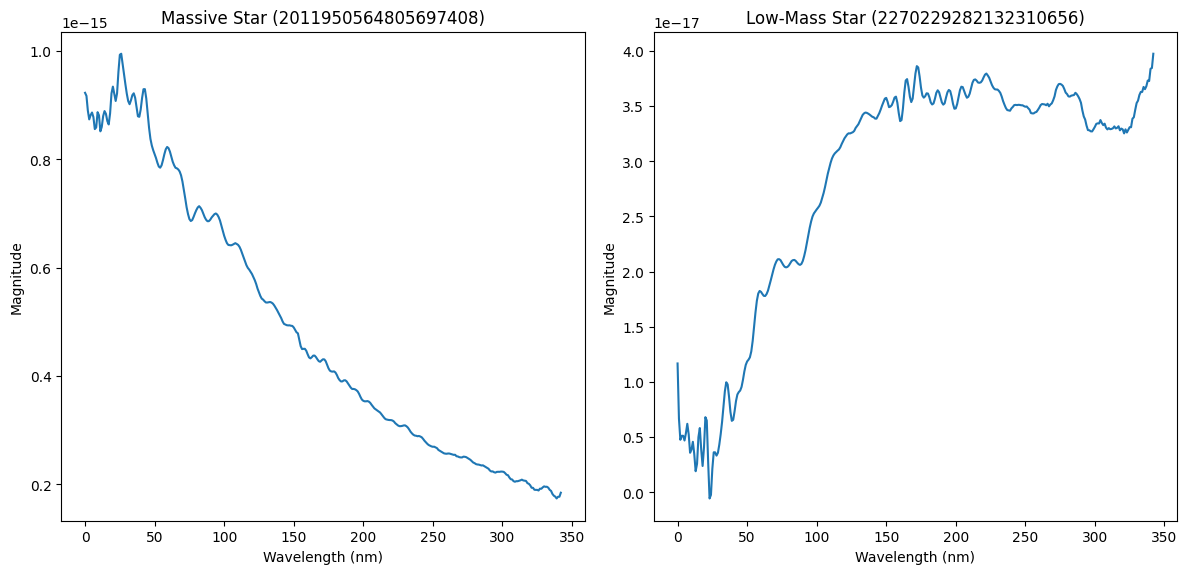

In [11]:
# rerun this cell to see random examples of different spectra


# Random sample from 'M' category (massive star)
sample_ms = df[df['Cat'] == 'M'].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df['source_id'].iloc[sample_ms].values[0]

# Random sample from 'LM' category (low-mass star)
sample_lm = df[df['Cat'] == 'LM'].sample(n=1).index
flux_lm = df['flux'].iloc[sample_lm].values[0]
object_id_lm = df['source_id'].iloc[sample_lm].values[0]

plt.figure(figsize=(12, 6))

# Plot for 'M' category (massive star)
plt.subplot(1, 2, 1)
plt.plot(flux_ms)
plt.title(f"Massive Star ({object_id_ms})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

# Plot for 'LM' category (low-mass star)
plt.subplot(1, 2, 2)
plt.plot(flux_lm)
plt.title(f"Low-Mass Star ({object_id_lm})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [12]:
num_samples = df.shape[0]
spectrum_width = len(df['flux'][0])

num_samples_lm = df['Cat'].value_counts()['LM']
num_samples_m = df['Cat'].value_counts()['M']
num_classes = df['Cat'].nunique()

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

Number of total spectral samples: 18908
Number of bins in each spectra: 343
In the dataset, we have 9381 spectra for low mass stars and 9527 spectra for high mass stars.


In [13]:
X = df['flux'].to_numpy()
y = df['Cat'].to_numpy()

# encode categories
y = torch.from_numpy(np.where(y == 'M', 1, np.where(y == 'LM', 0, y)).astype(float))

# L2 normalization
X = torch.from_numpy(np.array([x / np.linalg.norm(x, keepdims=True) for x in X])).float()

In [14]:
def init_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [15]:
def extend_curves(curves):
    '''
    function to extended loss curves to the same length
    '''
    max_length = max(len(curve) for curve in curves)
    
    extended_curves = []
    for curve in curves:
        last_value = curve[-1]
        extended_curve = curve + [last_value] * (max_length - len(curve))
        extended_curves.append(extended_curve)
    
    return np.array(extended_curves)

def init_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
            
def fit_model(model, x_train, y_train, x_val=None, y_val=None, prt_steps = 1, verbose=True):
    
    model.apply(init_weights)

    # hyperparameters
    epochs = 50
    learning_rate = 1e-4
    batch_size = 64
    device = 'cuda'

    # early stopping
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0
    
    class_weights = torch.tensor(compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=y_train.numpy())).to(device)

    # model components
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    # move everything to gpu
    model.to(device)
    x_train = x_train.to(device)
    y_train = y_train.unsqueeze(1).to(device)
    x_val = x_val.to(device)
    y_val = y_val.unsqueeze(1).to(device)

    # metrics
    training_losses, validation_losses = [], []
    accuracy = []
    
    # lr cycling
    max_lr = 1e-3
    steps_per_epoch = (len(x_train) + batch_size - 1) // batch_size
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=steps_per_epoch, epochs=epochs)

    batch_start = torch.arange(0, len(x_train), batch_size)

    t = tqdm(range(epochs), dynamic_ncols=True)

    for epoch in t:
        t.set_description(f'Epoch {epoch+1}')
        
        model.train()
        running_loss = 0

        for start in batch_start:
            
            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            output = model(x_batch)
            loss = criterion(output, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * x_batch.size(0)

        train_loss = running_loss / len(x_train)
        training_losses.append(train_loss)
        if verbose and (epoch+1) % prt_steps == 0:
            print(f'Train loss: {train_loss:.4f}', end='\r')


        if x_val is not None and y_val is not None:
            model.eval()
            preds, labels = [], []

            with torch.no_grad():
                
                output = model(x_val)
                loss = criterion(output, y_val)

                probs = torch.sigmoid(output)
                pred = torch.round(probs).cpu().numpy().astype(float)
                
                preds.extend(pred)
                labels.extend(y_val.cpu().numpy())
                
                val_loss = loss.item()
            
            epoch_acc = accuracy_score(labels, preds)
            validation_losses.append(val_loss)
            accuracy.append(epoch_acc)
            if verbose and (epoch+1) % prt_steps == 0:
                print(f'Train loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {epoch_acc:.4f}', end='\r')

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'\nEarly stopping at epoch {epoch+1}')
                break

    return model, training_losses, validation_losses, accuracy

In [16]:
kfold = StratifiedKFold(n_splits=10)

training_losses_foldx, validation_losses_foldx, accuracy_scores_foldx, models = [], [], [], []

model = Wide(input_size=spectrum_width, output_size=y.unsqueeze(1).size(1), N=3)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    
    print(f"\nFitting fold {fold+1}")

    model, tr_loss, val_loss, acc = fit_model(model, X[train_idx], y[train_idx], X[val_idx], y[val_idx], prt_steps=1, verbose=True)
    models.append(model)
    training_losses_foldx.append(tr_loss)
    validation_losses_foldx.append(val_loss)
    accuracy_scores_foldx.append(acc)

training_losses = np.mean(extend_curves(training_losses_foldx), axis=0)
validation_losses = np.mean(extend_curves(validation_losses_foldx), axis=0)
accuracy_scores = np.mean(extend_curves(accuracy_scores_foldx), axis=0)


Fitting fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.2972, Val Loss: 0.2827, Accuracy: 0.9180
Fitting fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.2571, Val Loss: 0.2550, Accuracy: 0.9212
Fitting fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.2265, Val Loss: 0.2206, Accuracy: 0.9276
Fitting fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.2717, Val Loss: 0.2801, Accuracy: 0.9159
Fitting fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.2205, Val Loss: 0.2202, Accuracy: 0.9291
Fitting fold 6


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.2148, Val Loss: 0.2150, Accuracy: 0.9318
Fitting fold 7


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.2444, Val Loss: 0.2461, Accuracy: 0.9223
Fitting fold 8


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.2272, Val Loss: 0.2505, Accuracy: 0.9075
Fitting fold 9


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.2203, Val Loss: 0.2123, Accuracy: 0.9286
Fitting fold 10


  0%|          | 0/50 [00:00<?, ?it/s]

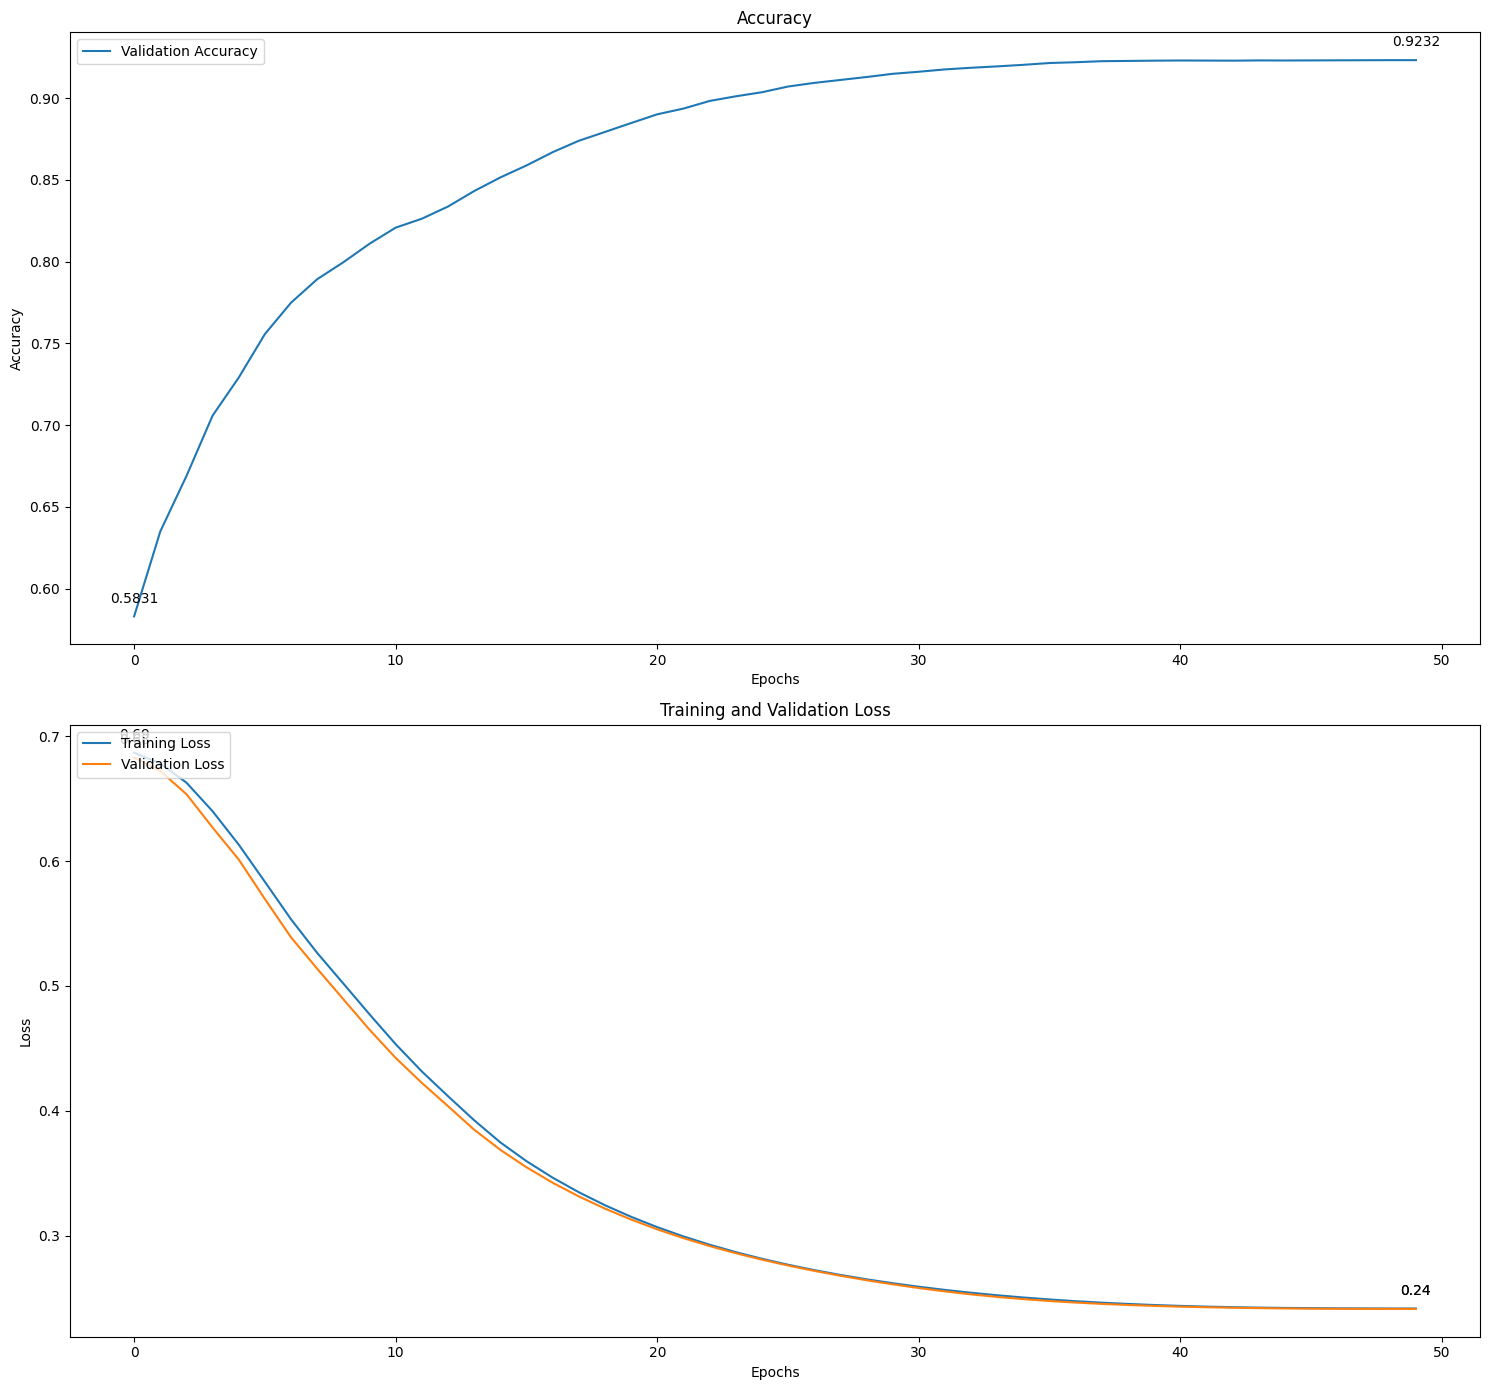

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14))

ax1.plot(accuracy_scores, label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy')
ax1.legend(loc='upper left')

ax1.annotate(f'{accuracy_scores[0]:.4f}', (0, accuracy_scores[0]), textcoords="offset points", xytext=(0,10), ha='center')
ax1.annotate(f'{accuracy_scores[-1]:.4f}', (len(accuracy_scores)-1, accuracy_scores[-1]), textcoords="offset points", xytext=(0,10), ha='center')

ax2.plot(training_losses, label='Training Loss')
ax2.plot(validation_losses, label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend(loc='upper left')

ax2.annotate(f'{training_losses[0]:.2f}', (0, training_losses[0]), textcoords="offset points", xytext=(0,10), ha='center')
ax2.annotate(f'{training_losses[-1]:.2f}', (len(training_losses)-1, training_losses[-1]), textcoords="offset points", xytext=(0,10), ha='center')
ax2.annotate(f'{validation_losses[0]:.2f}', (0, validation_losses[0]), textcoords="offset points", xytext=(0,10), ha='center')
ax2.annotate(f'{validation_losses[-1]:.2f}', (len(validation_losses)-1, validation_losses[-1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

In [ ]:
torch.save(models,'../trained_models/wide.pth')